# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Downloading Dataset

In [3]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Character-based encoding

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Dataloaders

In [5]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [6]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [7]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0,
                        )

In [8]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [10]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [11]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [12]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [13]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m, backend="eager")

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Training

In [28]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]c:\importante\Master\Procesamiento lenguaje natural 2\Proyecto\TinyGPT\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
loss 2.10532: 100%|██████████| 11246/11246 [5:22:39<00:00,  1.72s/it]      


Epoch 1 training loss: 2.0986


val_loss 2.08725: 100%|██████████| 1246/1246 [00:05<00:00, 212.49it/s]


Epoch 1 validation loss: 2.0411


loss 2.09991: 100%|██████████| 11246/11246 [15:40<00:00, 11.96it/s]


Epoch 2 training loss: 2.0753


val_loss 2.08725: 100%|██████████| 1246/1246 [00:05<00:00, 242.06it/s]

Epoch 2 validation loss: 2.0411
Training complete.


In [22]:
model = TinyGPT(config)                      # build architecture
state_dict = torch.load("model_eager.pth", map_location=device)
# If keys come from a compiled model, they start with "_orig_mod."
if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k.replace("_orig_mod.", "", 1)  # remove only first occurrence
        new_state_dict[new_key] = v
    state_dict = new_state_dict

model = TinyGPT(config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

### Quick test 

In [23]:
generate("To be", max_new_tokens=100,use_cache=True) 

"To beld ar neat, feayses forendy.\n\nCIRIOLARUS:\nI 'CGend that. Sind:\nYoure ame bul' she nos berivem, she y"

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [24]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
) -> Optional[str]:
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # choose conditioning context
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # logits of the last position: (1, vocab_size)
        last_logits = logits[:, -1, :]

        # decide whether to sample or go greedy
        do_sampling = (
            (temperature is not None and temperature != 1.0)
            or (top_k is not None and top_k > 0)
            or (top_p is not None and 0.0 < top_p < 1.0)
        )

        if not do_sampling:
            # --- PURE GREEDY ---
            next_token = torch.argmax(last_logits, dim=-1, keepdim=True)
        else:
            # --- TEMPERATURE SCALING ---
            if temperature is None or temperature <= 0.0:
                temp = 1.0
            else:
                temp = temperature
            logits_scaled = last_logits / temp

            # work on a copy for filtering
            logits_filtered = logits_scaled.clone()

            # --- TOP-K FILTERING ---
            if top_k is not None and top_k > 0:
                values, _ = torch.topk(logits_filtered, top_k, dim=-1)
                min_values = values[..., -1, None]
                logits_filtered[logits_filtered < min_values] = float("-inf")

            # --- TOP-P (NUCLEUS) FILTERING ---
            if top_p is not None and 0.0 < top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(
                    logits_filtered, descending=True, dim=-1
                )
                sorted_probs = F.softmax(sorted_logits, dim=-1)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

                sorted_mask = cumulative_probs > top_p
                sorted_mask[..., 0] = False  # always keep at least the top token
                sorted_logits[sorted_mask] = float("-inf")

                # scatter back to original order
                logits_filtered = torch.full_like(logits_filtered, float("-inf"))
                logits_filtered.scatter_(-1, sorted_indices, sorted_logits)

            # fallback: if everything got nuked, use unfiltered scaled logits
            if torch.all(torch.isinf(logits_filtered)):
                probs = F.softmax(logits_scaled, dim=-1)
            else:
                probs = F.softmax(logits_filtered, dim=-1)

            next_token = torch.multinomial(probs, num_samples=1)

        # append token
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())



## Compare generate vs generateV2

Add your comments and findings

In [ ]:
torch.save(model.state_dict(), "model_eager.pth")


In [28]:
result_1 = generate("To be", max_new_tokens=100,use_cache=True)
result_2_standard = generateV2("To be", max_new_tokens=100,use_cache=True)
only_greedy = generateV2("To be", max_new_tokens=100, temperature=1.0, top_k=0, top_p=1.0,)
high_temperature = generateV2("To be", max_new_tokens=100, temperature= 1.5, use_cache=True)
low_temperature = generateV2("To be", max_new_tokens=100, temperature= 0.5, use_cache=True)


In [26]:
result_1

"To beathe wourst thestis ard\nFar yo liofne, ing locke, andlus sall viand pre, co'my at cases ers, fortpec"

In [ ]:
result_2_standard

'To be the thes ore\nAndit to for the so shald the a the bed shice and\nWhand to the mond sot the thes wers,'

In [29]:
only_greedy

'To be the the the the the the the the the the the the the the the the the the the the the the the the the'

In [30]:
high_temperature

'To ben im, arsen alt, sthes wanceng shy\nThanen a souris orstof a she shant, so anse.\n\nFingart a sonds ban'

In [31]:
low_temperature

'To be st her hare he and the the thears theat the the a she more the the a the the theall the bearthe the'

The new generate function appears to distinguish that "be" in the frase "to be" is a word. When using the greedy method the model becomes repetitive, this is likely because "the" is the highest probability token after "the" which makes it loop on the same word.

## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [16]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self, config: GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        ) 

    def forward(self, x) -> torch.Tensor:
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe_args.num_experts)

    def forward(self, x):
        return self.proj(x)

In [17]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

        assert (
            len(self.experts) == self.args.num_experts
        ), "Number of experts must match moe_args.num_experts"

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, n_embd) or (N, n_embd)
        Returns:
            y: same shape as x
        """
        gate_logits = self.gate(x)
        gate_probs = F.softmax(gate_logits, dim=-1)  

        expert_outputs = [expert(x) for expert in self.experts]

        expert_outputs = torch.stack(expert_outputs, dim=-2)

        gate_probs_expanded = gate_probs.unsqueeze(-1)

        y = torch.sum(gate_probs_expanded * expert_outputs, dim=-2)

        return y


In [18]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args,
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [20]:
config.ff_class = MoEFFN                 # replace FFN with MoE FFN
config.moe_args = MoEArgs(num_experts=4, num_experts_per_token=1)

# Training TinyGPT-MoE


In [21]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe, backend="eager")  

In [43]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [44]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]c:\importante\Master\Procesamiento lenguaje natural 2\Proyecto\TinyGPT\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
loss 2.07148: 100%|██████████| 11246/11246 [38:49<00:00,  4.83it/s]


Epoch 1 training loss: 2.0190


val_loss 1.99004: 100%|██████████| 1246/1246 [00:07<00:00, 167.95it/s]


Epoch 1 validation loss: 1.9857


loss 2.05984: 100%|██████████| 11246/11246 [38:49<00:00,  4.83it/s]


Epoch 2 training loss: 1.9630


val_loss 1.99003: 100%|██████████| 1246/1246 [00:07<00:00, 175.80it/s]

Epoch 2 validation loss: 1.9857
Training complete.


In [45]:
torch.save(model_moe.state_dict(), "model_moe_eager.pth")

In [22]:
model = TinyGPT(config)                      # build architecture
state_dict = torch.load("model_moe_eager.pth", map_location=device)
# If keys come from a compiled model, they start with "_orig_mod."
if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k.replace("_orig_mod.", "", 1)  # remove only first occurrence
        new_state_dict[new_key] = v
    state_dict = new_state_dict

model = TinyGPT(config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
result_1 = generate("To be", max_new_tokens=100,use_cache=True)
result_2_standard = generateV2("To be", max_new_tokens=100,use_cache=True)
only_greedy = generateV2("To be", max_new_tokens=100, temperature=1.0, top_k=0, top_p=1.0,)
high_temperature = generateV2("To be", max_new_tokens=100, temperature= 1.5, use_cache=True)
low_temperature = generateV2("To be", max_new_tokens=100, temperature= 0.5, use_cache=True)

In [26]:
result_1

"To be grustan ome;\nGir wirengut ball nodth gies, dics sthe that: him\nt no o's dif miceaves beich:\nYours, "

In [27]:
result_2_standard

'To berictisent thim\nFin wor thit thall shey treare man and the the hit the the mour ow him the the witind'

In [28]:
only_greedy

'To be the the the the the the the the the the the the the the the the the the the the the the the the the'

In [29]:
high_temperature

'To betes the sare, sund ham\nArs hare, hey hay youll mes, he hee to as mer blay, sun toun ownt headieds ou'

In [30]:
low_temperature

'To be the and the the the hat the wis shis and the the the an the sto be the the a the se the the the the'

## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [31]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


In [33]:
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()

In [34]:
model_original = TinyGPT(config)                      # build architecture
state_dict = torch.load("model_eager.pth", map_location=device)
# If keys come from a compiled model, they start with "_orig_mod."
if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k.replace("_orig_mod.", "", 1)  # remove only first occurrence
        new_state_dict[new_key] = v
    state_dict = new_state_dict

model_original = TinyGPT(config).to(device)
model_original.load_state_dict(state_dict)

<All keys matched successfully>

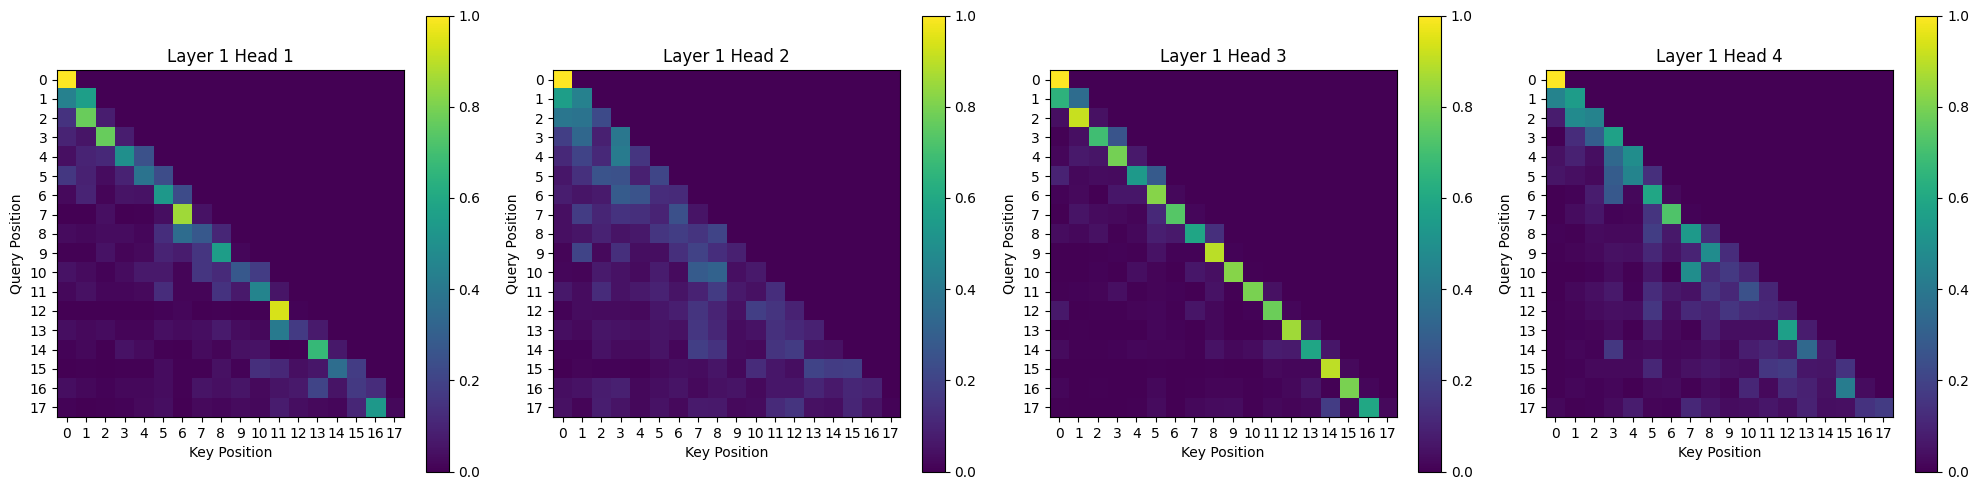

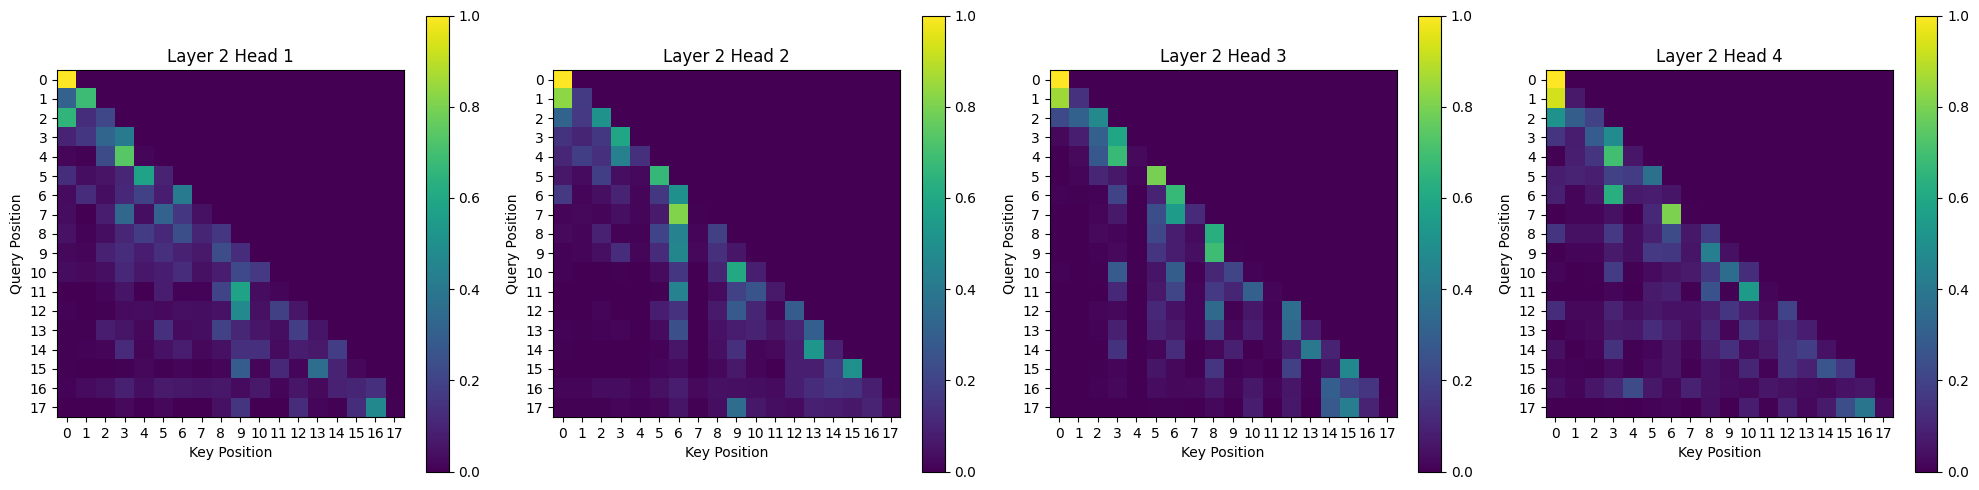

In [32]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

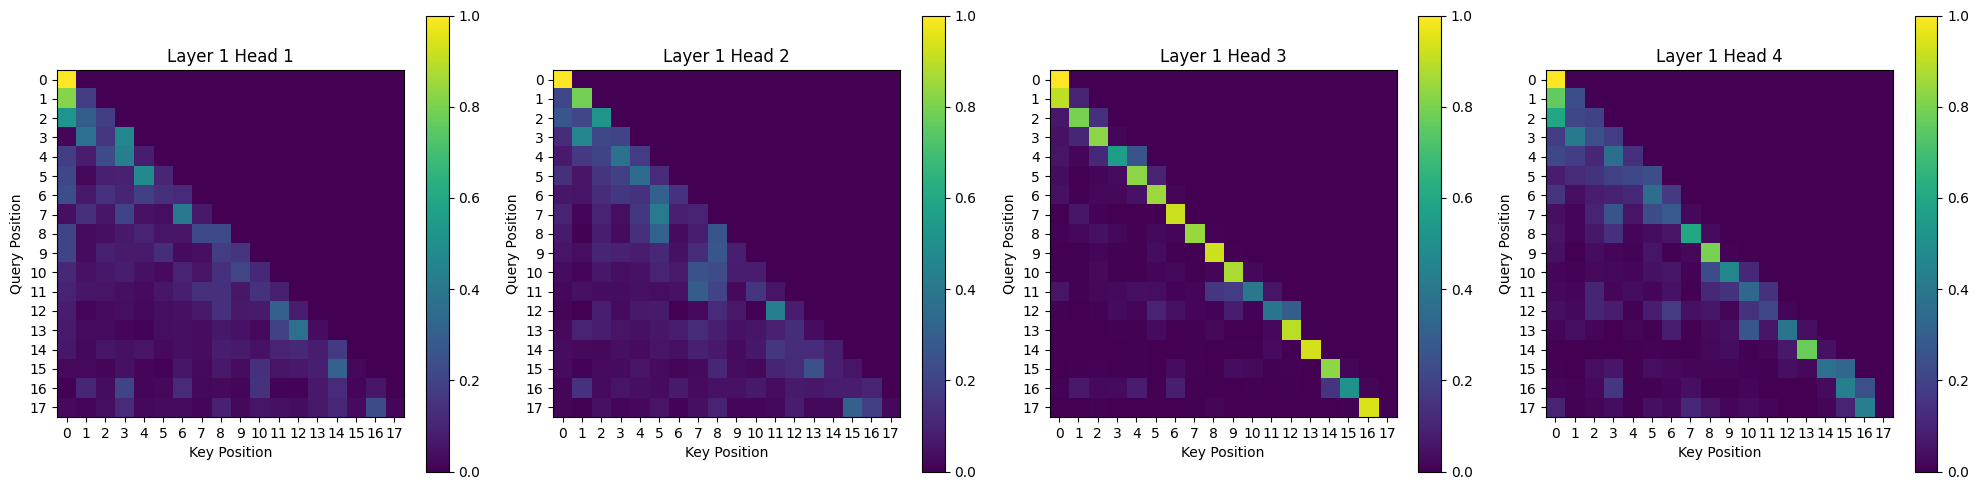

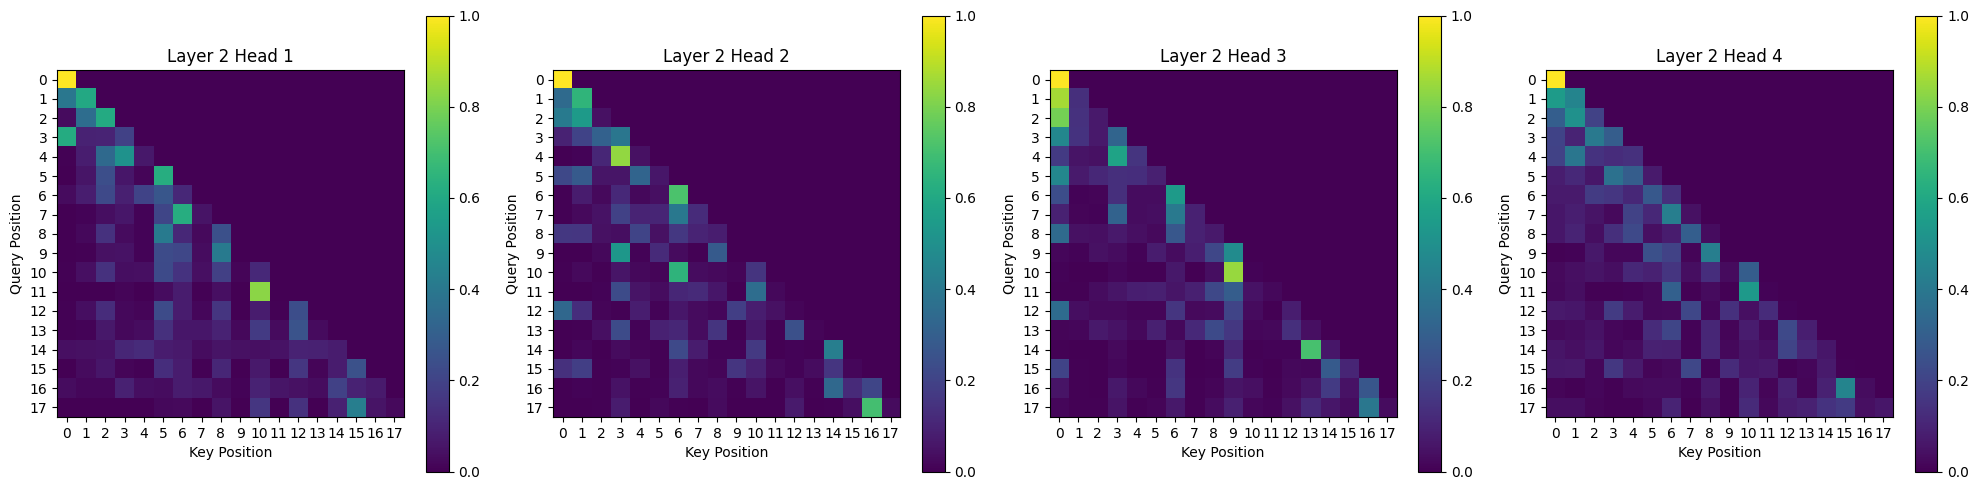

In [35]:
visualize_attention(model_original, prompt)

# Conclusions

- Even though our manual tests have shown little information to speculate on the performance of the Mixture of Experts model, this is due to the small amount of text we use to train the model itself. The heat map tells us a bit more, the MoE heatmap showcases a stronger diagonal, meaning that the model has learned that the most amount of information is closer to the token that it is analysing at the moment, while our first version shows a more distributed, less pronounced heatmap, which suggests a more random behaviour. 

# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

